## Predicting the effects of U.S. Meat Export Industry on the Environment

### A time-series analysis of U.S Livestock and Meat Exports worldwide
#### Kristin Kusheva
#### 14th Oct 2019


###### Loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('LivestockMeat_Exports.csv')
df.head()

,SOURCE_ID,HS_CODE,COMMODITY_DESC,GEOGRAPHY_CODE,GEOGRAPHY_DESC,ATTRIBUTE_DESC,UNIT_DESC,YEAR_ID,TIMEPERIOD_ID,AMOUNT
0,63,102900000.0,"Bovine animals, live, nesoi",2150,Honduras,"US Export, QTY",NO,1996,12,5.0
1,63,102900000.0,"Bovine animals, live, nesoi",2190,Nicaragua,"US Export, QTY",NO,2000,2,90.0
2,63,102900000.0,"Bovine animals, live, nesoi",2250,Panama,"US Export, QTY",NO,2001,11,12.0
3,63,102900000.0,"Bovine animals, live, nesoi",2250,Panama,"US Export, QTY",NO,2008,10,12.0
4,63,102900000.0,"Bovine animals, live, nesoi",2320,Bermuda,"US Export, QTY",NO,2007,4,49.0


###### Cleaning duplicates that are present in the data

In [2]:
df.loc[df[' COMMODITY_DESC'] == 'Pork', ' HS_CODE']= df.loc[df[' COMMODITY_DESC'] == 'Pork', ' HS_CODE'].fillna(0)

In [3]:
df1 = df.dropna(subset=[' HS_CODE'])

In [4]:
df1[df1[' HS_CODE'].isnull()]


,SOURCE_ID,HS_CODE,COMMODITY_DESC,GEOGRAPHY_CODE,GEOGRAPHY_DESC,ATTRIBUTE_DESC,UNIT_DESC,YEAR_ID,TIMEPERIOD_ID,AMOUNT


In [5]:
df_final = df1.loc[:, (df1.columns).isin([' COMMODITY_DESC', 'GEOGRAPHY_DESC',
                                          ' YEAR_ID', ' TIMEPERIOD_ID', 'AMOUNT', ' UNIT_DESC'])]

In [6]:
group_by =  df_final.loc[df_final.groupby([' COMMODITY_DESC', ' YEAR_ID',
                                           ' TIMEPERIOD_ID', 'GEOGRAPHY_DESC'])['AMOUNT'].idxmax()]
df_final_final = df_final.loc[group_by.index, :]

Cleaning the commodity description and perform checks to ensure that the new data looks good

In [7]:
df_final_final['Main_Desc'] = df_final_final[' COMMODITY_DESC'].apply(lambda x: x.replace("\'", '').split(",")[0])
df_final_final['Main_Desc'] = df_final_final['Main_Desc'].apply(lambda x: x.replace('*', ''))
df_final_final['Main_Desc'].head()


1160935    Beef Boneless Processed
1161249    Beef Boneless Processed
1160894    Beef Boneless Processed
1155605    Beef Boneless Processed
1155874    Beef Boneless Processed
Name: Main_Desc, dtype: object

In [8]:
len(df_final_final)

424245

In [9]:
len(df_final)

914065

In [10]:
dff = df_final_final.drop(columns = ' COMMODITY_DESC')

###### Converting all the amounts to be in the same unit of measurement - kilograms

In [11]:
def conversion(row):
    if row[' UNIT_DESC'] == 'CWE':
        return row['AMOUNT'] * 0.45 *0.5 
    elif row[' UNIT_DESC'] == 'DOZ':
        return row['AMOUNT']*0.7
    elif row[' UNIT_DESC'] == 'NO':
        if row['Main_Desc'] == 'Bovine animals':
            return row['AMOUNT']*395
        elif row['Main_Desc'] == 'Cattle':
            return row['AMOUNT']*275
        elif row['Main_Desc'] == 'Goats':
            return row['AMOUNT']*70
        elif row['Main_Desc'] == 'Swine':
            return row['AMOUNT']*200
        elif row['Main_Desc'] == 'Sheep':
            return row['AMOUNT']*75 
    return row['AMOUNT']

In [12]:
dff['Final_amount'] = dff.apply(lambda x: conversion(x), axis=1 )

###### Employing machine learning NLP lemmatising techniques to transform each commodity description into a more simplified commodity in order to clean the data so it will be suitable for aggregation.

In [13]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kristine\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kristine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
def replace_ (column):
    '''
    This function will extract the noun (for example: beef, pork) from commodity description
    It uses nltk lemmatizer and get the first noun from the text
    If noun is swine, return pork or if bird, return chicken
    Returns the originial text if no noun is found
    
    '''
    tokens = nltk.word_tokenize(column.lower())
    lemmatizer = WordNetLemmatizer() 
    lemma = [lemmatizer.lemmatize(word, wordnet.NOUN) for word in tokens] 
    tagged = nltk.pos_tag(lemma)
    noun = [x[0] for x in tagged if x[1] == 'NN' or  x[1] =='NNS']
    if noun:
        if noun[0] == 'meat' and len(noun) > 1:
            temp = noun[1]
        else:
            temp = noun[0]
    else:
         temp = column
    if temp == 'swine': 
         return 'pork'
    if temp == 'bird':
        return 'chicken'
    return temp

In [15]:
dff['Nouns'] = dff['Main_Desc'].apply(lambda x: replace_(x))
dff.head()



,GEOGRAPHY_DESC,UNIT_DESC,YEAR_ID,TIMEPERIOD_ID,AMOUNT,Main_Desc,Final_amount,Nouns
1160935,Antigua & Barbuda,CWE,1989,1,2315.419467,Beef Boneless Processed,520.969380,beef
1161249,Austria,CWE,1989,1,10750.161813,Beef Boneless Processed,2418.786408,beef
1160894,Bahamas,CWE,1989,1,6925.209134,Beef Boneless Processed,1558.172055,beef
1155605,Bermuda,CWE,1989,1,9261.677870,Beef Boneless Processed,2083.877521,beef
1155874,British Virgin Islands,CWE,1989,1,1130.646389,Beef Boneless Processed,254.395438,beef


In [16]:
dff.head()

,GEOGRAPHY_DESC,UNIT_DESC,YEAR_ID,TIMEPERIOD_ID,AMOUNT,Main_Desc,Final_amount,Nouns
1160935,Antigua & Barbuda,CWE,1989,1,2315.419467,Beef Boneless Processed,520.969380,beef
1161249,Austria,CWE,1989,1,10750.161813,Beef Boneless Processed,2418.786408,beef
1160894,Bahamas,CWE,1989,1,6925.209134,Beef Boneless Processed,1558.172055,beef
1155605,Bermuda,CWE,1989,1,9261.677870,Beef Boneless Processed,2083.877521,beef
1155874,British Virgin Islands,CWE,1989,1,1130.646389,Beef Boneless Processed,254.395438,beef


###### Getting all data for country Bulgaria

In [17]:
df_Bulgaria = dff[dff['GEOGRAPHY_DESC'] == 'Bulgaria']

In [18]:
df_Bulgaria[df_Bulgaria[' YEAR_ID'] == 2019]

,GEOGRAPHY_DESC,UNIT_DESC,YEAR_ID,TIMEPERIOD_ID,AMOUNT,Main_Desc,Final_amount,Nouns
317698,Bulgaria,CWE,2019,3,47050.976585,Hams,10586.469732,ham
863163,Bulgaria,CWE,2019,3,47050.976585,Pork,10586.469732,pork


In [19]:
df_Bulgaria_agg =  df_Bulgaria.loc[:, (df_Bulgaria.columns).isin([' YEAR_ID', 'Final_amount'])]

In [20]:
df_Bulgaria_agg1 = df_Bulgaria_agg.groupby([' YEAR_ID']).agg(sum).reset_index()

In [21]:
df_Bulgaria_agg1 = df_Bulgaria_agg1.drop(df_Bulgaria_agg1.tail(1).index) 

###### Predicting US meat export to Bulgaria using ARIMA

In [22]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

In [23]:
model = ARIMA(df_Bulgaria_agg1['Final_amount'], order=(0,0,2))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:           Final_amount   No. Observations:                   23
Model:                     ARMA(0, 2)   Log Likelihood                -376.177
Method:                       css-mle   S.D. of innovations        3061935.210
Date:                Sat, 12 Oct 2019   AIC                            760.354
Time:                        18:28:25   BIC                            764.896
Sample:                             0   HQIC                           761.496
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                2.24e+06   8.47e+05      2.645      0.016     5.8e+05     3.9e+06
ma.L1.Final_amount     0.3044      0.205      1.484      0.153      -0.098       0.706
ma.L2.Final_amount  

In [24]:
pred = model_fit.predict(len(df_Bulgaria_agg1['Final_amount']), len(df_Bulgaria_agg1['Final_amount']) + 2)

In [25]:
pred

23    1.674825e+06
24    2.178664e+06
25    2.239824e+06
dtype: float64

In [26]:
pred2 = pd.DataFrame(columns = [' YEAR_ID', 'Final_amount'])
pred2['Final_amount'] = pred
pred2[' YEAR_ID'] = range(2019,2022)



In [27]:
pred2

,YEAR_ID,Final_amount
23,2019,1.674825e+06
24,2020,2.178664e+06
25,2021,2.239824e+06


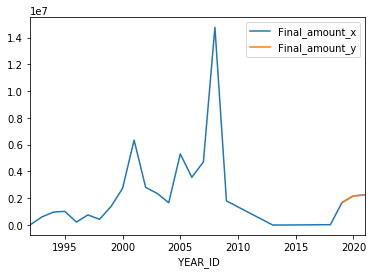

In [28]:
df_Bulgaria_agg1.index = df_Bulgaria_agg1[' YEAR_ID']
pred2.index = pred2[' YEAR_ID']
df_all = pd.merge(df_Bulgaria_agg1['Final_amount'], pred2['Final_amount'],
                  how = 'outer', left_index=True, right_index=True)
import math

for i in df_all.index:
    if math.isnan(df_all.loc[i, 'Final_amount_x']):
        df_all.loc[i, 'Final_amount_x'] = df_all.loc[i, 'Final_amount_y']
df_all.plot()

In [29]:
df_lstm = df_Bulgaria_agg1.reset_index(drop = True)

In [30]:
df_lstm = df_lstm.drop(columns = ' YEAR_ID')


In [31]:
df_next5_ = pred2.drop(columns = ' YEAR_ID')

In [32]:
df_lstm1 = pd.concat([df_lstm, df_next5_]).reset_index()

In [33]:
df_lstm1 = df_lstm1.drop(columns = 'index')

###### Predicting meat US export to Bulgaria using LSTM 

Using TensorFlow backend.
W1012 18:28:31.111827  1560 deprecation_wrapper.py:119] From C:\ProgramData\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1012 18:28:31.142782  1560 deprecation_wrapper.py:119] From C:\ProgramData\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1012 18:28:31.156708  1560 deprecation_wrapper.py:119] From C:\ProgramData\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1012 18:28:31.382146  1560 deprecation_wrapper.py:119] From C:\ProgramData\Miniconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1012 18:28:31.598526  1560 deprecation.py:323] Fr

Epoch 1/100
 - 1s - loss: 0.0372
Epoch 2/100
 - 0s - loss: 0.0312
Epoch 3/100
 - 0s - loss: 0.0266
Epoch 4/100
 - 0s - loss: 0.0226
Epoch 5/100
 - 0s - loss: 0.0201
Epoch 6/100
 - 0s - loss: 0.0178
Epoch 7/100
 - 0s - loss: 0.0162
Epoch 8/100
 - 0s - loss: 0.0155
Epoch 9/100
 - 0s - loss: 0.0145
Epoch 10/100
 - 0s - loss: 0.0143
Epoch 11/100
 - 0s - loss: 0.0137
Epoch 12/100
 - 0s - loss: 0.0136
Epoch 13/100
 - 0s - loss: 0.0135
Epoch 14/100
 - 0s - loss: 0.0133
Epoch 15/100
 - 0s - loss: 0.0133
Epoch 16/100
 - 0s - loss: 0.0133
Epoch 17/100
 - 0s - loss: 0.0132
Epoch 18/100
 - 0s - loss: 0.0131
Epoch 19/100
 - 0s - loss: 0.0131
Epoch 20/100
 - 0s - loss: 0.0131
Epoch 21/100
 - 0s - loss: 0.0130
Epoch 22/100
 - 0s - loss: 0.0131
Epoch 23/100
 - 0s - loss: 0.0129
Epoch 24/100
 - 0s - loss: 0.0129
Epoch 25/100
 - 0s - loss: 0.0129
Epoch 26/100
 - 0s - loss: 0.0128
Epoch 27/100
 - 0s - loss: 0.0129
Epoch 28/100
 - 0s - loss: 0.0127
Epoch 29/100
 - 0s - loss: 0.0128
Epoch 30/100
 - 0s - lo

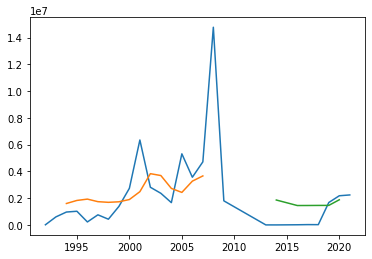

In [34]:
# LSTM for meat export from USA to Bulgaria problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = df_lstm1
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2016, 2017,
       2018, 2019, 2020, 2021], scaler.inverse_transform(dataset))
plt.plot([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2016, 2017,
       2018, 2019, 2020, 2021], trainPredictPlot)
plt.plot([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2016, 2017,
       2018, 2019, 2020, 2021], testPredictPlot)
plt.show()

###### Using GridSearch to optimise the parameters of the ARIMA modelling

In [35]:

import warnings
warnings.filterwarnings("ignore")

In [36]:
df_Bulgaria_agg12 = df_Bulgaria_agg1.drop(columns = ' YEAR_ID')

In [37]:
df_Bulgaria_agg12.to_csv(r'C:\Users\Kristine\Desktop\export_dataframe.csv', index=True)

In [38]:
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)

In [39]:
Bulgaria = pd.read_csv('export_dataframe.csv', header=0, index_col=0)

In [40]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(Bulgaria.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=25049067415620.559
ARIMA(0, 0, 1) MSE=27801990024448.055
ARIMA(0, 0, 2) MSE=58544693118881.094
ARIMA(0, 1, 0) MSE=36551228262284.602
ARIMA(0, 2, 0) MSE=99522940780443.203
ARIMA(1, 0, 0) MSE=30963278631458.477
ARIMA(1, 1, 0) MSE=50447138873812.812
ARIMA(1, 2, 0) MSE=82064213919069.922
ARIMA(2, 0, 0) MSE=35112008630203.906
ARIMA(2, 1, 0) MSE=64621074977007.086
ARIMA(4, 0, 0) MSE=51282464096208.406
ARIMA(4, 1, 0) MSE=69816655304355.422
ARIMA(6, 0, 0) MSE=66368163244411.617
Best ARIMA(0, 0, 0) MSE=25049067415620.559


###### Exploration of data on pork import in Bulgaria from USA

In [41]:
df_BG = df_Bulgaria.drop(columns = [' TIMEPERIOD_ID', 'GEOGRAPHY_DESC', 'AMOUNT'])

In [42]:
BG_pork = df_BG[df_BG['Nouns'] == 'pork']


In [43]:
BG_pork = BG_pork.groupby([' YEAR_ID']).agg(sum).reset_index()

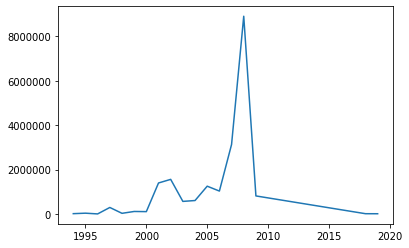

In [44]:
plt.plot(BG_pork[' YEAR_ID'], BG_pork['Final_amount'])

In [45]:
BG_pork

,YEAR_ID,Final_amount
0,1994,1.455679e+04
1,1995,3.603709e+04
2,1996,3.024356e+03
3,1997,2.934259e+05
4,1998,3.005675e+04
5,1999,1.131374e+05
6,2000,1.059730e+05
7,2001,1.395515e+06
8,2002,1.558263e+06
9,2003,5.663809e+05


In [46]:
add = [ (2010, 0) , (2011, 0), (2012, 0), (2013, 0), (2014, 0), (2015, 0), (2016, 0), (2017, 0), (2018, 0)] 

In [47]:
dfObj = pd.DataFrame(add, columns = [' YEAR_ID' , 'Final_amount'])

In [48]:
df_row = pd.concat([BG_pork, dfObj])

In [49]:
df_row = df_row.reset_index()

In [50]:
df_row = df_row.sort_values(' YEAR_ID')

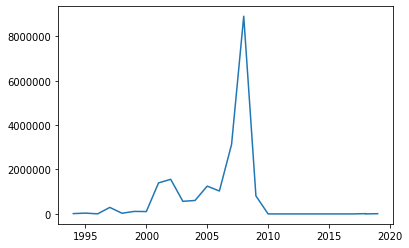

In [51]:
plt.plot(df_row[' YEAR_ID'], df_row[ 'Final_amount'])

###### Getting the data for country Brazil and predict the meat export from US using ARIMA

In [52]:
df_Brazil = dff[dff['GEOGRAPHY_DESC'] == 'Brazil']
df_Brazil_agg =  df_Brazil.loc[:, (df_Brazil.columns).isin([' YEAR_ID', 'Final_amount'])]
df_Brazil_agg1 = df_Brazil_agg.groupby([' YEAR_ID']).agg(sum).reset_index()
df_Brazil_agg1 = df_Brazil_agg1.drop(df_Brazil_agg1.tail(1).index) 

In [53]:
model = ARIMA(df_Brazil_agg1['Final_amount'], order=(0,0,2))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:           Final_amount   No. Observations:                   30
Model:                     ARMA(0, 2)   Log Likelihood                -450.110
Method:                       css-mle   S.D. of innovations         785456.894
Date:                Sat, 12 Oct 2019   AIC                            908.220
Time:                        18:28:45   BIC                            913.825
Sample:                             0   HQIC                           910.013
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.872e+06   2.86e+05      6.546      0.000    1.31e+06    2.43e+06
ma.L1.Final_amount     0.5838      0.157      3.730      0.001       0.277       0.891
ma.L2.Final_amount  

In [54]:
pred = model_fit.predict(start=len(df_Brazil_agg1['Final_amount']), end=len(df_Brazil_agg1['Final_amount']) + 2)

In [55]:
pred

30    2.274840e+06
31    2.234843e+06
32    1.871863e+06
dtype: float64

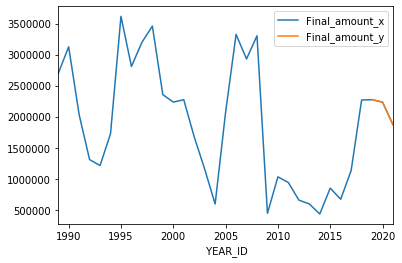

In [56]:
pred2 = pd.DataFrame(columns = [' YEAR_ID', 'Final_amount'])
pred2['Final_amount'] = pred
pred2[' YEAR_ID'] = range(2019,2022)

    
df_Brazil_agg1.index = df_Brazil_agg1[' YEAR_ID']
pred2.index = pred2[' YEAR_ID']
df_all = pd.merge(df_Brazil_agg1['Final_amount'], pred2['Final_amount'], 
                  how = 'outer', left_index=True, right_index=True)
import math

for i in df_all.index:
    if math.isnan(df_all.loc[i, 'Final_amount_x']):
        df_all.loc[i, 'Final_amount_x'] = df_all.loc[i, 'Final_amount_y']
df_all.plot()

###### Predicting meat export from US using LSTM

Epoch 1/100
 - 1s - loss: 0.3264
Epoch 2/100
 - 0s - loss: 0.2865
Epoch 3/100
 - 0s - loss: 0.2491
Epoch 4/100
 - 0s - loss: 0.2198
Epoch 5/100
 - 0s - loss: 0.1921
Epoch 6/100
 - 0s - loss: 0.1691
Epoch 7/100
 - 0s - loss: 0.1491
Epoch 8/100
 - 0s - loss: 0.1326
Epoch 9/100
 - 0s - loss: 0.1186
Epoch 10/100
 - 0s - loss: 0.1108
Epoch 11/100
 - 0s - loss: 0.1012
Epoch 12/100
 - 0s - loss: 0.0967
Epoch 13/100
 - 0s - loss: 0.0931
Epoch 14/100
 - 0s - loss: 0.0902
Epoch 15/100
 - 0s - loss: 0.0902
Epoch 16/100
 - 0s - loss: 0.0877
Epoch 17/100
 - 0s - loss: 0.0880
Epoch 18/100
 - 0s - loss: 0.0869
Epoch 19/100
 - 0s - loss: 0.0874
Epoch 20/100
 - 0s - loss: 0.0865
Epoch 21/100
 - 0s - loss: 0.0865
Epoch 22/100
 - 0s - loss: 0.0865
Epoch 23/100
 - 0s - loss: 0.0863
Epoch 24/100
 - 0s - loss: 0.0864
Epoch 25/100
 - 0s - loss: 0.0865
Epoch 26/100
 - 0s - loss: 0.0864
Epoch 27/100
 - 0s - loss: 0.0861
Epoch 28/100
 - 0s - loss: 0.0864
Epoch 29/100
 - 0s - loss: 0.0862
Epoch 30/100
 - 0s - lo

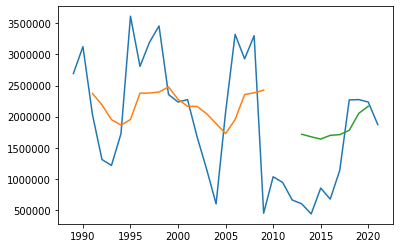

In [57]:
df_lstm = df_Brazil_agg1.reset_index(drop = True)
df_lstm = df_lstm.drop(columns = ' YEAR_ID')
df_next5_ = pred2.drop(columns = ' YEAR_ID')
df_lstm1 = pd.concat([df_lstm, df_next5_])

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = df_lstm1
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(range(1989,2022),scaler.inverse_transform(dataset))
plt.plot(range(1989,2022),trainPredictPlot)
plt.plot(range(1989,2022),testPredictPlot)
plt.show()



###### Using GridSearch to optimise the parameters of ARIMA

In [58]:
df_Brazil_agg12 = df_Brazil_agg1.drop(columns = ' YEAR_ID')
df_Brazil_agg12.to_csv(r'C:\Users\Kristine\Downloads\export_dataframe1.csv', index=True)
Brazil = pd.read_csv('export_dataframe1.csv', header=0, index_col=0)
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(Brazil.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1666354706118.256
ARIMA(0, 0, 1) MSE=1222010159233.575
ARIMA(0, 1, 0) MSE=997670191868.061
ARIMA(0, 1, 1) MSE=1004383826476.587
ARIMA(0, 1, 2) MSE=1513743674012.422
ARIMA(0, 2, 0) MSE=2391507176880.328
ARIMA(1, 0, 0) MSE=943662069827.736
ARIMA(1, 0, 1) MSE=1125588714070.397
ARIMA(1, 1, 0) MSE=1000020793165.490
ARIMA(1, 2, 0) MSE=1625684006868.248
ARIMA(1, 2, 1) MSE=1224157264459.846
ARIMA(2, 0, 0) MSE=1092081502702.112
ARIMA(2, 1, 0) MSE=1089494776855.763
ARIMA(2, 1, 1) MSE=1027216619187.683
ARIMA(2, 2, 0) MSE=1849689712890.289
ARIMA(2, 2, 1) MSE=1409690610839.928
ARIMA(4, 0, 0) MSE=1300187779753.075
ARIMA(4, 0, 1) MSE=1261809775462.551
ARIMA(4, 1, 0) MSE=1117307438782.250
ARIMA(4, 1, 1) MSE=1146288882110.734
ARIMA(4, 2, 0) MSE=1605880445081.808
ARIMA(6, 0, 0) MSE=1495240726766.830
ARIMA(6, 1, 0) MSE=1220776485763.966
ARIMA(6, 2, 0) MSE=1733758306015.151
ARIMA(8, 1, 0) MSE=1421011075219.787
Best ARIMA(1, 0, 0) MSE=943662069827.736


###### Data analysis for all countries

In [60]:
dff3 = dff.drop( columns = [' UNIT_DESC', ' YEAR_ID', 'Nouns', ' TIMEPERIOD_ID', 'AMOUNT', 'Main_Desc'])
top_10 = dff3.groupby(['GEOGRAPHY_DESC']).sum().reset_index()

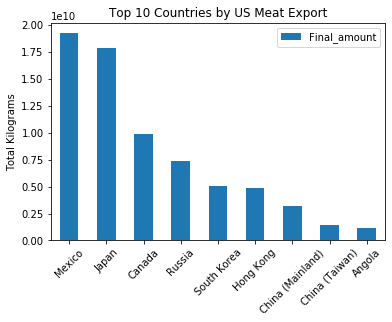

In [61]:
import matplotlib.pyplot as plt
sorted_ = top_10.sort_values('Final_amount', ascending=False).head(10)
sorted_ = sorted_[sorted_['GEOGRAPHY_DESC'] != 'World']
sorted_.plot('GEOGRAPHY_DESC','Final_amount', kind = 'bar', title = 'Top 10 Countries by US Meat Export')
plt.ylabel('Total Kilograms')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

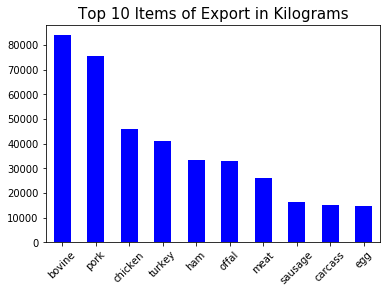

In [62]:
graph_by_items = dff['Nouns'].value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis = 'x', labelsize = 10, rotation = 90)
ax.tick_params(axis = 'y', labelsize = 10)
ax.set_title('Top 10 Items of Export in Kilograms', fontsize = 15)
plt.xticks(rotation=45)
graph_by_items[:10].plot(ax=ax, kind='bar', color='blue')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

###### Predicting the meat export from US to the world using ARIMA

In [63]:
df_world = dff[dff['GEOGRAPHY_DESC'] == 'World']

In [64]:
df_world_agg =  df_world.loc[:, (df_world.columns).isin([' YEAR_ID', 'Final_amount'])]
df_world_agg1 = df_world_agg.groupby([' YEAR_ID']).agg(sum).reset_index()

In [65]:
df_world_aggr2 = df_world_agg1.drop(df_world_agg1.tail(1).index) 

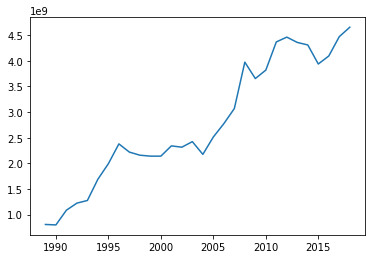

In [66]:
plt.plot(range(1989,2019),df_world_aggr2['Final_amount'])

In [67]:
model = ARIMA(df_world_aggr2['Final_amount'], order=(4,0,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:           Final_amount   No. Observations:                   30
Model:                     ARMA(4, 0)   Log Likelihood                -628.257
Method:                       css-mle   S.D. of innovations      283024774.070
Date:                Sun, 13 Oct 2019   AIC                           1268.513
Time:                        21:36:59   BIC                           1276.920
Sample:                             0   HQIC                          1271.203
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.787e+09   1.32e+09      2.119      0.044    2.09e+08    5.37e+09
ar.L1.Final_amount     1.1381      0.176      6.461      0.000       0.793       1.483
ar.L2.Final_amount  

In [68]:
pred = model_fit.predict(start=len(df_world_aggr2['Final_amount']), end=len(df_world_aggr2['Final_amount']) + 1)
pred2 = pd.DataFrame(columns = ['Final_amount', ' YEAR_ID'])
pred2['Final_amount'] = pred
pred2[' YEAR_ID'] = range(2019,2021)

In [69]:
df_world_aggr2['Final_amount']

0     8.070360e+08
1     7.983359e+08
2     1.085671e+09
3     1.223402e+09
4     1.275056e+09
5     1.689907e+09
6     1.993245e+09
7     2.378915e+09
8     2.218897e+09
9     2.158636e+09
10    2.140019e+09
11    2.140021e+09
12    2.340209e+09
13    2.314884e+09
14    2.422851e+09
15    2.174734e+09
16    2.514132e+09
17    2.773567e+09
18    3.068837e+09
19    3.973741e+09
20    3.653600e+09
21    3.818390e+09
22    4.368478e+09
23    4.462165e+09
24    4.358225e+09
25    4.309254e+09
26    3.937654e+09
27    4.094074e+09
28    4.471361e+09
29    4.654870e+09
Name: Final_amount, dtype: float64

In [70]:
pred2

,Final_amount,YEAR_ID
30,4.693121e+09,2019
31,4.738009e+09,2020


##### Calculations

##### Usage of water

In [71]:
#total export of meat in mln kilograms for 2019 and 2020
(4.693121e+09 + 4.738009e+09)

9431130000.0

In [72]:
(4.738009e+09 - 4.693121e+09) + (4.693121e+09 - 4.654870e+09)

83139000.0

In [73]:
#the difference between 2019 and 2018 in billion of litres of water
(4.693121e+09 - 4.654870e+09) * 9000

344259000000.0

In [74]:
#total litres in 2019 trillion
4.693121e+09*9000

42238089000000.0

In [75]:
#total litres in 2020
4.738009e+09 * 9000

42642081000000.0

344 bilion litres of water more for 2019 compared to 2018

In [76]:
(4.738009e+09 - 4.693121e+09) * 9000

403992000000.0

403 bilion litres for 2020 compared to 2019

total 707 bilion litres more compared to the figure in 2018

###### Usage of land

50 sq metres per kilo of meat

In [77]:
(4.693121e+09 - 4.654870e+09) * 50

1912550000.0

In [78]:
1912550000.0 / (1 * 1000 * 1000)

1912.55

1912 $km^{2}$ for 2019 more than the land usage in 2018

In [79]:
(4.738009e+09 - 4.693121e+09) * 50 / (1 * 1000 * 1000)

2244.4

In 2020 we will need 2244 $km^{2}$ more land than in 2019 

1912 + 2244 = 4156 $km^{2}$ additional land compared to 2018

###### Gridsearch World + LSTM

In [80]:
  
df_world_aggr2.index = df_world_aggr2[' YEAR_ID']
pred2.index = pred2[' YEAR_ID']
df_all = pd.merge(df_world_aggr2['Final_amount'], pred2['Final_amount'], 
                  how = 'outer', left_index=True, right_index=True)


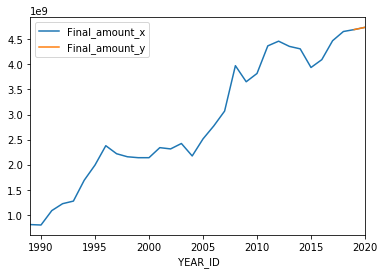

In [81]:
import math

for i in df_all.index:
    if math.isnan(df_all.loc[i, 'Final_amount_x']):
        df_all.loc[i, 'Final_amount_x'] = df_all.loc[i, 'Final_amount_y']
df_all.plot()

In [82]:
df_world_agg12 = df_world_agg1.drop(columns = ' YEAR_ID')
df_world_agg12.to_csv(r'C:\Users\Kristine\Downloads\export_dataframe12.csv', index=True)
World = pd.read_csv('export_dataframe12.csv', header=0, index_col=0)
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(World.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=2994686773033170944.000
ARIMA(0, 0, 1) MSE=1081056682988112384.000
ARIMA(0, 1, 0) MSE=631997201646556416.000
ARIMA(0, 1, 1) MSE=645816457067651200.000
ARIMA(0, 1, 2) MSE=639783335991928704.000
ARIMA(0, 2, 0) MSE=834453192242998272.000
ARIMA(0, 2, 1) MSE=758256041312238464.000
ARIMA(1, 0, 0) MSE=563139925193340096.000
ARIMA(1, 1, 0) MSE=652416798169466112.000
ARIMA(1, 2, 0) MSE=845311901556741632.000
ARIMA(2, 0, 0) MSE=618383846142263168.000
ARIMA(2, 1, 0) MSE=649492920337055104.000
ARIMA(2, 1, 1) MSE=700428467219433088.000
ARIMA(2, 2, 0) MSE=784159934176890112.000
ARIMA(2, 2, 1) MSE=794453738377408384.000
ARIMA(4, 0, 0) MSE=685699419637442432.000
ARIMA(4, 1, 0) MSE=736361277206629504.000
ARIMA(4, 1, 1) MSE=781326347649212800.000
ARIMA(4, 2, 0) MSE=825799417238415488.000
ARIMA(6, 1, 0) MSE=830865191875646976.000
ARIMA(6, 2, 0) MSE=834627554217880192.000
Best ARIMA(1, 0, 0) MSE=563139925193340096.000


Epoch 1/100
 - 3s - loss: 0.1446
Epoch 2/100
 - 0s - loss: 0.1211
Epoch 3/100
 - 0s - loss: 0.0981
Epoch 4/100
 - 0s - loss: 0.0816
Epoch 5/100
 - 0s - loss: 0.0645
Epoch 6/100
 - 0s - loss: 0.0517
Epoch 7/100
 - 0s - loss: 0.0416
Epoch 8/100
 - 0s - loss: 0.0332
Epoch 9/100
 - 0s - loss: 0.0273
Epoch 10/100
 - 0s - loss: 0.0234
Epoch 11/100
 - 0s - loss: 0.0207
Epoch 12/100
 - 0s - loss: 0.0188
Epoch 13/100
 - 0s - loss: 0.0178
Epoch 14/100
 - 0s - loss: 0.0171
Epoch 15/100
 - 0s - loss: 0.0168
Epoch 16/100
 - 0s - loss: 0.0163
Epoch 17/100
 - 0s - loss: 0.0160
Epoch 18/100
 - 0s - loss: 0.0156
Epoch 19/100
 - 0s - loss: 0.0154
Epoch 20/100
 - 0s - loss: 0.0151
Epoch 21/100
 - 0s - loss: 0.0148
Epoch 22/100
 - 0s - loss: 0.0147
Epoch 23/100
 - 0s - loss: 0.0143
Epoch 24/100
 - 0s - loss: 0.0139
Epoch 25/100
 - 0s - loss: 0.0136
Epoch 26/100
 - 0s - loss: 0.0133
Epoch 27/100
 - 0s - loss: 0.0133
Epoch 28/100
 - 0s - loss: 0.0128
Epoch 29/100
 - 0s - loss: 0.0125
Epoch 30/100
 - 0s - lo

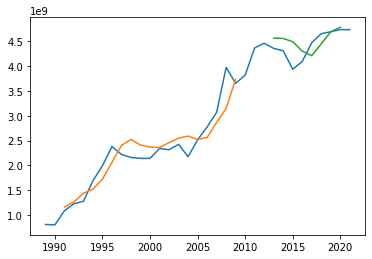

In [83]:
pred11 = model_fit.predict(start=len(df_world_aggr2['Final_amount']), end=len(df_world_aggr2['Final_amount']) + 2)
pred22 = pd.DataFrame(columns = ['Final_amount', ' YEAR_ID'])
pred22['Final_amount'] = pred11
pred22[' YEAR_ID'] = range(2019,2022)
df_lstm = df_world_aggr2.reset_index(drop = True)
df_lstm = df_lstm.drop(columns = ' YEAR_ID')
df_next5_ = pred22.drop(columns = ' YEAR_ID')
df_lstm1 = pd.concat([df_lstm, df_next5_])

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = df_lstm1
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(range(1989,2022),scaler.inverse_transform(dataset))
plt.plot(range(1989,2022),trainPredictPlot)
plt.plot(range(1989,2022),testPredictPlot)
plt.show()


### Analysis of the Predictions

###### Bulgaria – the import from USA will rise during the next 3 years. We see that since 2009 there was not import of pork from the US but from 2018 till mid 2019 in total there were 23 tonnes of pork imported from the US. This might be as a result of the recent swine fever that affected the pig agriculture in many countries in the Eastern Europe.

###### Brazil – the import of meat is decreasing during the next 3 years which might mean that they started producing their own meat. If this is true, Brazil needs more land in order to fulfill their demand. Amazon fires – on purpose or a convenient coincidence?

###### World – the export of meat is rising during the next 2 years. This is concerning because as we saw that 41% of the land in the US is used for agricultural purpose. The percentage will rise even further.


### Conclusion

##### For 2019 and 2020 the world will import total of 9 billion kg of meat from the US – 4.69 billion in 2019 and 4.73 billion in 2020. This is in total  83 million kilograms more than in  2018.
##### In 2019 the meat export from the Us will require the use of 42.2 trillion litres of water whereas in 2020 it is predicted to be even more – 42.6 trillion litres. This is in total 707 billion litres more compared to the numbers in 2018.
##### For 2019 and 2020 the world will need total of 4156 km2 more land to produce the demanded meat.

